<a href="https://colab.research.google.com/github/nugi1209/Virtual_Experience_KPMG_Data_Analytics/blob/master/KPMG_Virtual_Experience_2_Nugroho_Budianggoro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:
import pandas as pd
import seaborn as sns
import matplotlib
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

!pip install kneed
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [2]:
url = "https://github.com/nugi1209/Virtual_Experience_KPMG_Data_Analytics/blob/master/KPMG_VI_New_raw_data_update_final.xlsx?raw=true"
xls = pd.ExcelFile(url)

In [3]:
xls.sheet_names

['Title Sheet',
 'Transactions',
 'NewCustomerList',
 'CustomerDemographic',
 'CustomerAddress']

In [4]:
df_tr = pd.read_excel(url, sheet_name = 1, header = 1)
df_tr.columns

Index(['transaction_id', 'product_id', 'customer_id', 'transaction_date',
       'online_order', 'order_status', 'brand', 'product_line',
       'product_class', 'product_size', 'list_price', 'standard_cost',
       'product_first_sold_date'],
      dtype='object')

In [5]:
df_tr.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0
1,2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701.0
2,3,37,402,2017-10-16,0.0,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361.0
3,4,88,3135,2017-08-31,0.0,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,36145.0
4,5,78,787,2017-10-01,1.0,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,42226.0


In [6]:
df_nc = pd.read_excel(url, sheet_name = 2, header = 1)
df_nc["new_customer"] = True
df_nc["customer_id"] = 0
df_nc.columns

Index(['first_name', 'last_name', 'gender',
       'past_3_years_bike_related_purchases', 'DOB', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'owns_car', 'tenure', 'address', 'postcode', 'state', 'country',
       'property_valuation', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18',
       'Unnamed: 19', 'Unnamed: 20', 'Rank', 'Value', 'new_customer',
       'customer_id'],
      dtype='object')

In [7]:
df_cd = pd.read_excel(url, sheet_name = 3, header = 1)
df_cd["new_customer"] = False
df_cd.columns
df_cd.head()

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,default,owns_car,tenure,new_customer
0,1,Laraine,Medendorp,F,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,"""'",Yes,11.0,False
1,2,Eli,Bockman,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,<script>alert('hi')</script>,Yes,16.0,False
2,3,Arlin,Dearle,Male,61,1954-01-20,Recruiting Manager,Property,Mass Customer,N,2018-02-01 00:00:00,Yes,15.0,False
3,4,Talbot,NaN,Male,33,1961-10-03,NaN,IT,Mass Customer,N,() { _; } >_[$($())] { touch /tmp/blns.shellsh...,No,7.0,False
4,5,Sheila-kathryn,Calton,Female,56,1977-05-13,Senior Editor,NaN,Affluent Customer,N,NIL,Yes,8.0,False


In [8]:
df_ca = pd.read_excel(url, sheet_name = 4, header = 1)
df_ca.columns

Index(['customer_id', 'address', 'postcode', 'state', 'country',
       'property_valuation'],
      dtype='object')

TRANSACTIONS

In [9]:
df_tr.shape

(20000, 13)

In [10]:
df_tr = df_tr.loc[df_tr["order_status"] != "Cancelled"]

In [11]:
df_tr.shape

(19821, 13)

In [12]:
df_tr_pr = df_tr.groupby(["customer_id"], as_index = False).sum()
df_tr_pr["profit_per_customer"] = df_tr_pr["list_price"] - df_tr_pr['standard_cost']
# df_tr_pr.head()

In [13]:
keep_cols1 = ["customer_id", "profit_per_customer"]
df_tr_pr = df_tr_pr[keep_cols1]
df_tr_pr.head()

,customer_id,profit_per_customer
0,1,3018.09
1,2,2226.26
2,3,3362.81
3,4,220.57
4,5,2394.94


In [14]:
df_tr_lp = df_tr.sort_values("transaction_date").groupby("customer_id").tail(1)

In [15]:
benchmark_date = pd.to_datetime("2018-01-01")
df_tr_lp["days_to_latest_purchase"] = benchmark_date - pd.to_datetime(df_tr_lp["transaction_date"])
keep_cols2 = ["customer_id", "days_to_latest_purchase"]
df_tr_lp = df_tr_lp[keep_cols2]

In [16]:
df_tr_lp["days_to_latest_purchase"].dtypes

dtype('<m8[ns]')

In [17]:
df_tr_lp["days_to_latest_purchase"] = df_tr_lp["days_to_latest_purchase"].astype(str).str.replace(" days", "")
df_tr_lp["days_to_latest_purchase"] = df_tr_lp["days_to_latest_purchase"].astype(int)
df_tr_lp.head()

,customer_id,days_to_latest_purchase
13976,2807,355
7262,1846,335
8764,1544,331
5378,822,330
13825,2876,327


In [18]:
df_tr_fr = df_tr.groupby("customer_id", as_index=False).size()
df_tr_fr.head()

,customer_id,size
0,1,11
1,2,3
2,3,8
3,4,2
4,5,6


In [19]:
df_rfm = pd.merge(df_tr_pr, df_tr_lp, how="inner", on=["customer_id"])
df_rfm = pd.merge(df_rfm, df_tr_fr, how="inner", on=["customer_id"])
df_rfm = df_rfm.rename(columns={"size":"purchase_frequency"})
df_rfm["avg_purchase"] = df_rfm["profit_per_customer"] / df_rfm["purchase_frequency"]
df_rfm.head()

,customer_id,profit_per_customer,days_to_latest_purchase,purchase_frequency,avg_purchase
0,1,3018.09,9,11,274.371818
1,2,2226.26,130,3,742.086667
2,3,3362.81,104,8,420.351250
3,4,220.57,197,2,110.285000
4,5,2394.94,18,6,399.156667


In [20]:
df_rfm.isnull().sum()

customer_id                0
profit_per_customer        0
days_to_latest_purchase    0
purchase_frequency         0
avg_purchase               0
dtype: int64

In [21]:
# mpg = sns.load_dataset("mpg")

# # Plot miles per gallon against horsepower with other semantics
# sns.relplot(x="horsepower", y="mpg", hue="origin", size="weight",
#             sizes=(40, 400), alpha=.5, palette="muted",
#             height=6, data=mpg)

# df_plot1 = sns.load_dataset("df_rfm")
# sns.set_theme(style="white")
# sns.relplot(x="days_to_latest_purchase", y="purchase_frequency", 
#             hue="profit_per_customer", sizes=(5, 200), alpha=.5, palette="muted",
#             height=6, data=df_rfm)

In [22]:
df_cst = pd.merge(df_cd,df_ca, how="inner", on=["customer_id"])
keep_cols3 = ["customer_id",
              "gender", 
              'past_3_years_bike_related_purchases', 
              "DOB",
              "job_title",
              "job_industry_category",
              "wealth_segment",
              "owns_car",
              "tenure",
              "postcode",
              "state",
              "property_valuation",
              "deceased_indicator",
              "new_customer"]

df_cst = df_cst[keep_cols3]

df_cst.head()

,customer_id,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,owns_car,tenure,postcode,state,property_valuation,deceased_indicator,new_customer
0,1,F,93,1953-10-12,Executive Secretary,Health,Mass Customer,Yes,11.0,2016,New South Wales,10,N,False
1,2,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,Yes,16.0,2153,New South Wales,10,N,False
2,4,Male,33,1961-10-03,NaN,IT,Mass Customer,No,7.0,4211,QLD,9,N,False
3,5,Female,56,1977-05-13,Senior Editor,NaN,Affluent Customer,Yes,8.0,2448,New South Wales,4,N,False
4,6,Male,35,1966-09-16,NaN,Retail,High Net Worth,Yes,13.0,3216,VIC,9,N,False


In [23]:
df_nc = df_nc[keep_cols3]
list(df_nc.columns)

['customer_id',
 'gender',
 'past_3_years_bike_related_purchases',
 'DOB',
 'job_title',
 'job_industry_category',
 'wealth_segment',
 'owns_car',
 'tenure',
 'postcode',
 'state',
 'property_valuation',
 'deceased_indicator',
 'new_customer']

In [24]:
df_cst = pd.concat([df_cst, df_nc])
df_cst.head()

,customer_id,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,owns_car,tenure,postcode,state,property_valuation,deceased_indicator,new_customer
0,1,F,93,1953-10-12,Executive Secretary,Health,Mass Customer,Yes,11.0,2016,New South Wales,10,N,False
1,2,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,Yes,16.0,2153,New South Wales,10,N,False
2,4,Male,33,1961-10-03,NaN,IT,Mass Customer,No,7.0,4211,QLD,9,N,False
3,5,Female,56,1977-05-13,Senior Editor,NaN,Affluent Customer,Yes,8.0,2448,New South Wales,4,N,False
4,6,Male,35,1966-09-16,NaN,Retail,High Net Worth,Yes,13.0,3216,VIC,9,N,False


In [25]:
df_cst.shape

(4996, 14)

In [26]:
df_cst["gender"] = df_cst["gender"].replace({"F":"Female", "Femal":"Female", "M":"Male", "U": None})
df_cst["state"] = df_cst["state"].replace({"New South Wales":"NSW", "Victoria":"VIC"})
df_cst = df_cst.replace({"n/a": None, "Argiculture":"Agriculture"})
df_cst = df_cst.dropna()

In [27]:
df_cst.isnull().sum()

customer_id                            0
gender                                 0
past_3_years_bike_related_purchases    0
DOB                                    0
job_title                              0
job_industry_category                  0
wealth_segment                         0
owns_car                               0
tenure                                 0
postcode                               0
state                                  0
property_valuation                     0
deceased_indicator                     0
new_customer                           0
dtype: int64

In [28]:
df_cst.shape

(3597, 14)

In [29]:
df_cst["gender"].unique()

array(['Female', 'Male'], dtype=object)

In [30]:
df_cst["wealth_segment"].unique()

array(['Mass Customer', 'Affluent Customer', 'High Net Worth'],
      dtype=object)

In [31]:
df_cst["property_valuation"].unique()

array([10, 12,  4,  6,  8,  9,  7,  3,  5,  1,  2, 11])

In [32]:
df_cst.dtypes

customer_id                                     int64
gender                                         object
past_3_years_bike_related_purchases             int64
DOB                                    datetime64[ns]
job_title                                      object
job_industry_category                          object
wealth_segment                                 object
owns_car                                       object
tenure                                        float64
postcode                                        int64
state                                          object
property_valuation                              int64
deceased_indicator                             object
new_customer                                     bool
dtype: object

In [33]:
df_cst = df_cst.loc[df_cst["deceased_indicator"] == "N"]
df_cst = df_cst.drop(columns=["deceased_indicator"])

In [34]:
df_cst["age"] = benchmark_date - pd.to_datetime(df_cst["DOB"])
df_cst["age"].dtypes

dtype('<m8[ns]')

In [35]:
df_cst["age"] = df_cst["age"] / np.timedelta64(1,"Y")
df_cst["age"] = df_cst["age"].astype(int)
df_cst = df_cst.drop(columns=["DOB"])
df_cst.reset_index(inplace=True)
df_cst.head()

,index,customer_id,gender,past_3_years_bike_related_purchases,job_title,job_industry_category,wealth_segment,owns_car,tenure,postcode,state,property_valuation,new_customer,age
0,0,1,Female,93,Executive Secretary,Health,Mass Customer,Yes,11.0,2016,NSW,10,False,64
1,1,2,Male,81,Administrative Officer,Financial Services,Mass Customer,Yes,16.0,2153,NSW,10,False,37
2,7,9,Female,97,Business Systems Development Analyst,Agriculture,Affluent Customer,Yes,8.0,2023,NSW,12,False,44
3,9,12,Male,58,Nuclear Power Engineer,Manufacturing,Mass Customer,No,8.0,4557,QLD,4,False,23
4,10,13,Male,38,Developer I,Financial Services,High Net Worth,Yes,8.0,3799,VIC,6,False,62


In [36]:
len(df_cst[(df_cst["new_customer"]==True)])

735

In [37]:
len(df_cst[df_cst["new_customer"]==False])

2860

In [38]:
df_cst["job_title"].unique()

array(['Executive Secretary', 'Administrative Officer',
       'Business Systems Development Analyst', 'Nuclear Power Engineer',
       'Developer I', 'Account Executive', 'Junior Executive',
       'Geological Engineer', 'Project Manager', 'Safety Technician I',
       'Research Assistant I', 'Accounting Assistant III', 'Editor',
       'Research Nurse', 'Senior Quality Engineer',
       'Safety Technician III', 'Staff Accountant III', 'Legal Assistant',
       'Information Systems Manager', 'Social Worker',
       'Senior Cost Accountant', 'Assistant Media Planner',
       'Payment Adjustment Coordinator', 'Food Chemist', 'Accountant III',
       'Director of Sales', 'Senior Financial Analyst',
       'Registered Nurse', 'Computer Systems Analyst II',
       'Software Test Engineer II', 'Sales Associate', 'Paralegal',
       'VP Sales', 'Office Assistant III', 'Help Desk Operator',
       'Web Developer II', 'Research Associate', 'VP Product Management',
       'Statistician II', 'Au

In [39]:
df_cst["job_industry_category"].unique()

array(['Health', 'Financial Services', 'Agriculture', 'Manufacturing',
       'Telecommunications', 'Entertainment', 'Retail', 'Property', 'IT'],
      dtype=object)

<function matplotlib.pyplot.show>

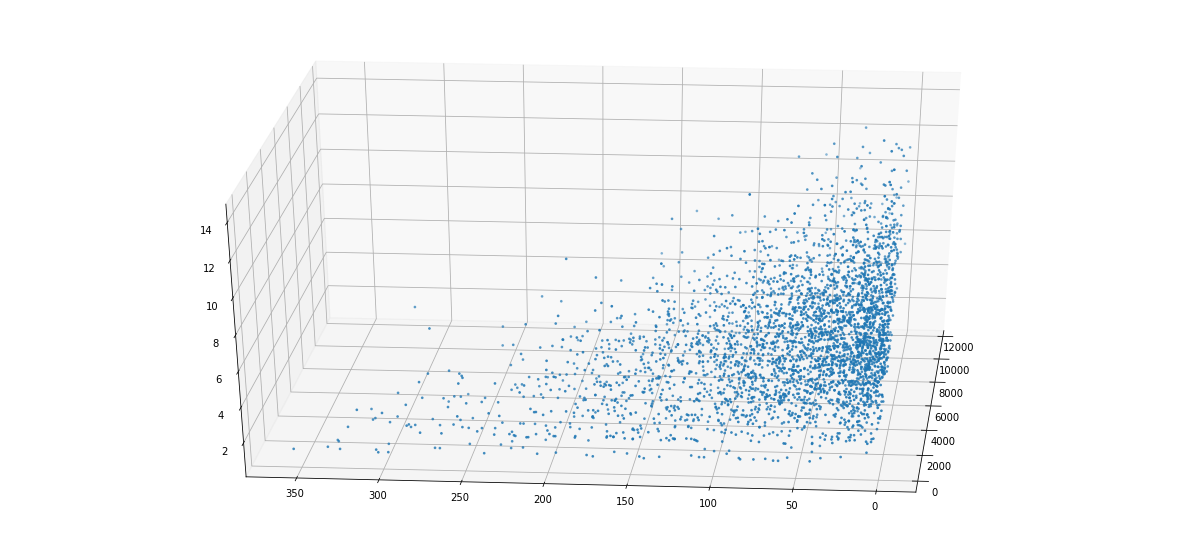

In [40]:
fig = plt.figure(figsize=(21,10))
ax = fig.add_subplot(111, projection = "3d")
ax.scatter(df_rfm['profit_per_customer'], df_rfm["days_to_latest_purchase"], df_rfm["purchase_frequency"], s=3)

ax.view_init(30, 185)
plt.show

In [41]:
df_rfm.columns

Index(['customer_id', 'profit_per_customer', 'days_to_latest_purchase',
       'purchase_frequency', 'avg_purchase'],
      dtype='object')

In [42]:
df_cst.columns

Index(['index', 'customer_id', 'gender', 'past_3_years_bike_related_purchases',
       'job_title', 'job_industry_category', 'wealth_segment', 'owns_car',
       'tenure', 'postcode', 'state', 'property_valuation', 'new_customer',
       'age'],
      dtype='object')

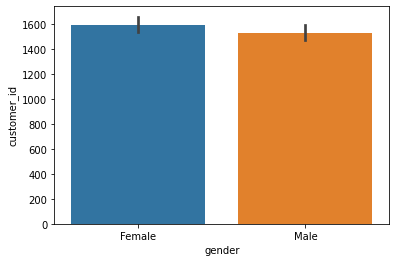

In [43]:
sns.barplot(data=df_cst, x='gender', y='customer_id')

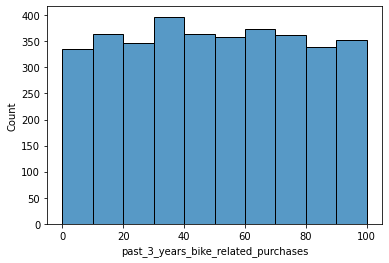

In [44]:
sns.histplot(data=df_cst, x="past_3_years_bike_related_purchases", binwidth=10)

In [45]:
df_cst["job_title"].value_counts()

Social Worker                   53
Cost Accountant                 48
Dental Hygienist                47
Chemical Engineer               47
Sales Representative            46
                                ..
Programmer Analyst IV            3
Accounting Assistant IV          3
Database Administrator II        3
Human Resources Assistant IV     3
Account Representative II        3
Name: job_title, Length: 195, dtype: int64

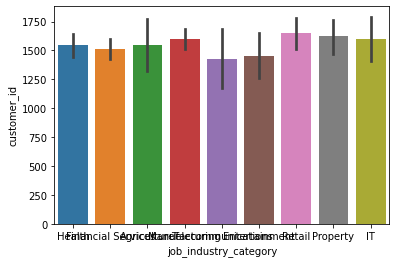

In [46]:
sns.barplot(data=df_cst, x='job_industry_category', y='customer_id')

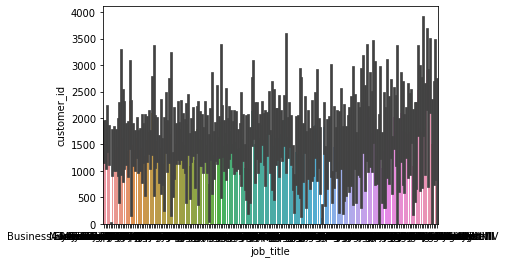

In [47]:
sns.barplot(data=df_cst, x='job_title', y='customer_id')

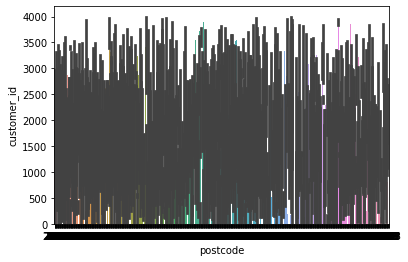

In [48]:
sns.barplot(data=df_cst,x='postcode', y='customer_id')

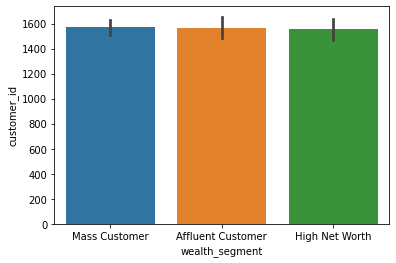

In [49]:
sns.barplot(data=df_cst, x='wealth_segment', y='customer_id')

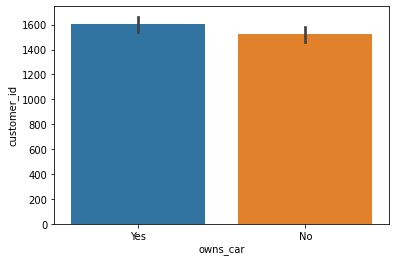

In [50]:
sns.barplot(data=df_cst, x='owns_car', y='customer_id')

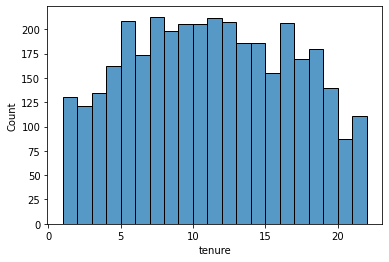

In [51]:
sns.histplot(data=df_cst, x="tenure", binwidth=1)

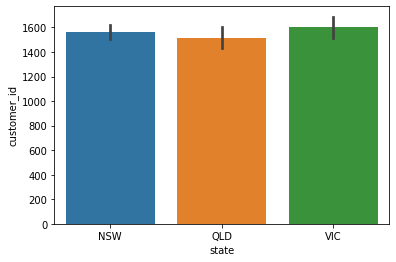

In [52]:
sns.barplot(data=df_cst, x='state', y='customer_id')

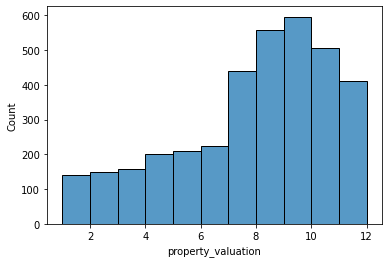

In [53]:
sns.histplot(data=df_cst, x="property_valuation", binwidth=1)

In [54]:
df_rfm.columns

Index(['customer_id', 'profit_per_customer', 'days_to_latest_purchase',
       'purchase_frequency', 'avg_purchase'],
      dtype='object')

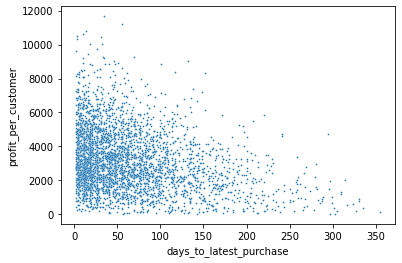

In [55]:
sns.scatterplot(data=df_rfm, y='profit_per_customer', x="days_to_latest_purchase", s=3)

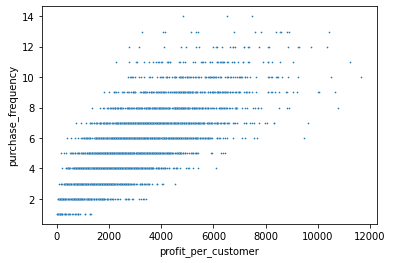

In [56]:
sns.scatterplot(data=df_rfm, x='profit_per_customer', y="purchase_frequency", s=3)

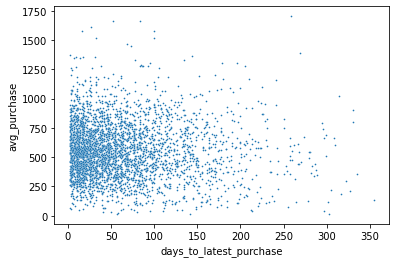

In [57]:
sns.scatterplot(data=df_rfm, y='avg_purchase', x="days_to_latest_purchase", s=3)

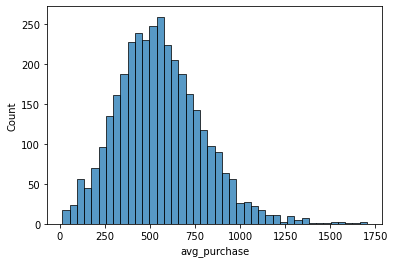

In [58]:
sns.histplot(data=df_rfm, x="avg_purchase")


In [59]:
df_cto = df_cst[df_cst["new_customer"]==False]
df_cto = pd.merge(df_cto, df_rfm, how='inner', on="customer_id")
df_cto.head()


,index,customer_id,gender,past_3_years_bike_related_purchases,job_title,job_industry_category,wealth_segment,owns_car,tenure,postcode,state,property_valuation,new_customer,age,profit_per_customer,days_to_latest_purchase,purchase_frequency,avg_purchase
0,0,1,Female,93,Executive Secretary,Health,Mass Customer,Yes,11.0,2016,NSW,10,False,64,3018.09,9,11,274.371818
1,1,2,Male,81,Administrative Officer,Financial Services,Mass Customer,Yes,16.0,2153,NSW,10,False,37,2226.26,130,3,742.086667
2,7,9,Female,97,Business Systems Development Analyst,Agriculture,Affluent Customer,Yes,8.0,2023,NSW,12,False,44,2353.11,80,6,392.185000
3,9,12,Male,58,Nuclear Power Engineer,Manufacturing,Mass Customer,No,8.0,4557,QLD,4,False,23,3540.03,69,7,505.718571
4,10,13,Male,38,Developer I,Financial Services,High Net Worth,Yes,8.0,3799,VIC,6,False,62,4337.38,29,7,619.625714


In [60]:
df_cto.describe()

,index,customer_id,past_3_years_bike_related_purchases,tenure,postcode,property_valuation,age,profit_per_customer,days_to_latest_purchase,purchase_frequency,avg_purchase
count,2522.000000,2522.000000,2522.000000,2522.000000,2522.000000,2522.000000,2522.000000,2522.000000,2522.000000,2522.000000,2522.000000
mean,1727.195876,1732.185964,49.397700,10.723632,2994.137193,7.481364,39.636003,3155.238236,63.830293,5.664948,553.424427
std,1008.817346,1008.834254,28.611169,5.681008,857.486949,2.832605,12.496534,1807.949831,58.774937,2.303084,237.263006
min,0.000000,1.000000,0.000000,1.000000,2000.000000,1.000000,15.000000,15.080000,2.000000,1.000000,15.080000
25%,845.750000,850.750000,25.000000,6.000000,2196.250000,6.000000,30.000000,1860.125000,20.000000,4.000000,389.860625
50%,1722.500000,1727.500000,48.000000,11.000000,2767.000000,8.000000,40.000000,2883.920000,46.000000,5.000000,537.123056
75%,2595.750000,2600.750000,73.000000,16.000000,3789.750000,10.000000,49.000000,4227.152500,88.000000,7.000000,695.638250
max,3492.000000,3497.000000,99.000000,22.000000,4883.000000,12.000000,86.000000,11668.950000,355.000000,14.000000,1702.550000


In [89]:
past_bike_purchase_bin = [0, 25, 50, 75, 100]
past_bike_purchase_label = ["D", "C", "B", "A"]
df_cto["past_bike_purchase_group"] = pd.cut(df_cto["past_3_years_bike_related_purchases"], bins=past_bike_purchase_bin, labels=past_bike_purchase_label)
age_bin = [10, 30, 50, 70, 90]
age_label = ["D", "C", "B", "A"]
df_cto["age_group"] = pd.cut(df_cto["age"], bins=age_bin, labels=age_label)
purchase_freq_bin = [0, 5, 10, 15]
purchase_freq_label = ["0-5", "6-10", "11-15"]
df_cto["purchase_freq_group"] = pd.cut(df_cto["purchase_frequency"], bins=purchase_freq_bin, labels=purchase_freq_label)
avg_purchase_bin = [0, 500, 1000, 1500, 2000]
avg_purchase_label = ["D", "C", "B", "A"]
df_cto["avg_purchase_group"] = pd.cut(df_cto["avg_purchase"], bins=avg_purchase_bin, labels=avg_purchase_label)
prop_val_bin = [0, 4, 8, 12]
prop_val_label = ["C", "B", "A"]
df_cto["property_valuation_group"] = pd.cut(df_cto["property_valuation"], bins=prop_val_bin, labels=prop_val_label)
df_cto.head()

,index,customer_id,gender,past_3_years_bike_related_purchases,job_title,job_industry_category,wealth_segment,owns_car,tenure,postcode,state,property_valuation,new_customer,age,profit_per_customer,days_to_latest_purchase,purchase_frequency,avg_purchase,past_bike_purchase_group,age_group,purchase_freq_group,avg_purchase_group,property_valuation_group
0,0,1,Female,93,Executive Secretary,Health,Mass Customer,Yes,11.0,2016,NSW,10,False,64,3018.09,9,11,274.371818,A,B,11-15,D,A
1,1,2,Male,81,Administrative Officer,Financial Services,Mass Customer,Yes,16.0,2153,NSW,10,False,37,2226.26,130,3,742.086667,A,C,0-5,C,A
2,7,9,Female,97,Business Systems Development Analyst,Agriculture,Affluent Customer,Yes,8.0,2023,NSW,12,False,44,2353.11,80,6,392.185000,A,C,6-10,D,A
3,9,12,Male,58,Nuclear Power Engineer,Manufacturing,Mass Customer,No,8.0,4557,QLD,4,False,23,3540.03,69,7,505.718571,B,D,6-10,C,C
4,10,13,Male,38,Developer I,Financial Services,High Net Worth,Yes,8.0,3799,VIC,6,False,62,4337.38,29,7,619.625714,C,B,6-10,C,B


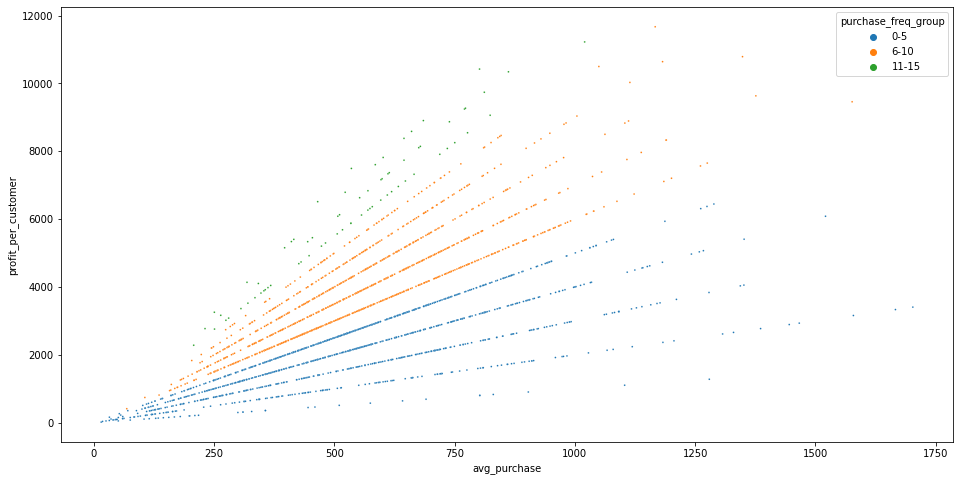

In [62]:
fig, ax = plt.subplots(figsize=[16,8])
sns.scatterplot(data=df_cto, x='avg_purchase', y="profit_per_customer", s=3, hue="purchase_freq_group")

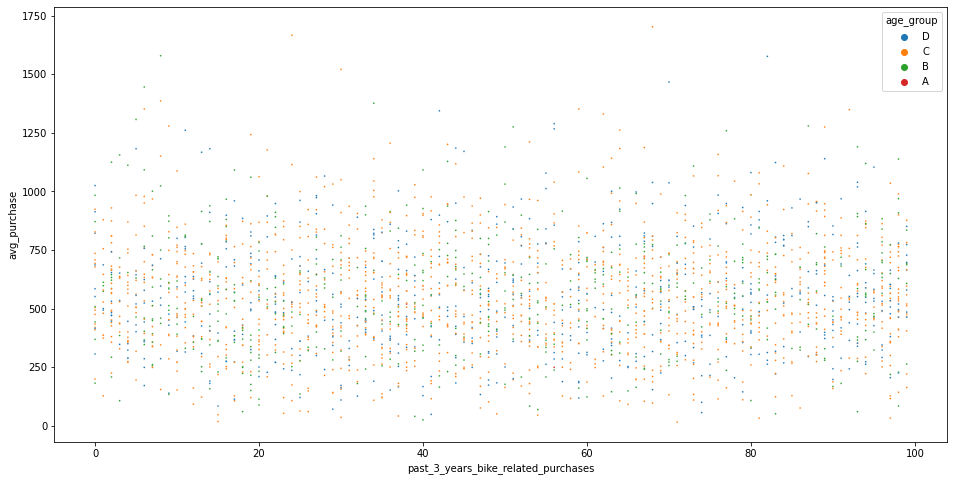

In [63]:
fig, ax = plt.subplots(figsize=[16,8])
sns.scatterplot(data=df_cto, x='past_3_years_bike_related_purchases', y="avg_purchase", hue="age_group", s=3)

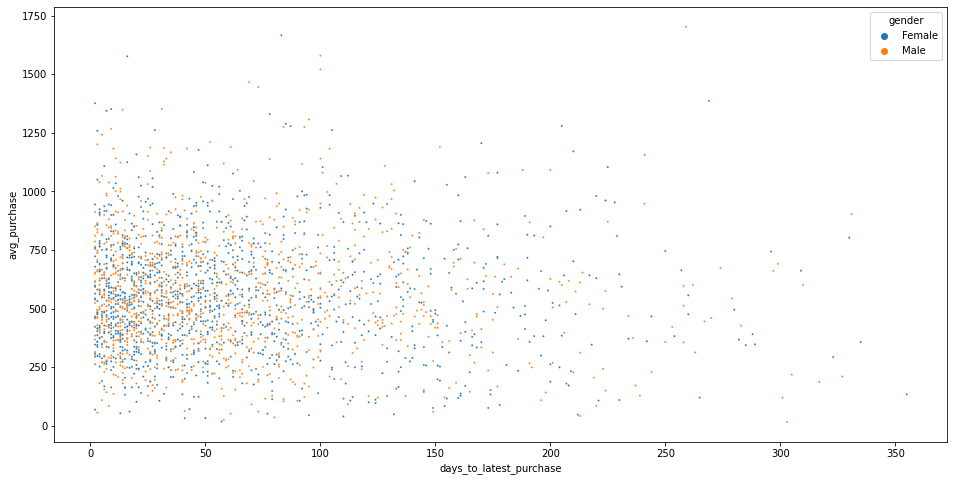

In [72]:
fig, ax = plt.subplots(figsize=[16,8])
sns.scatterplot(data=df_cto, x='days_to_latest_purchase', y="avg_purchase", hue="gender", s=4)


<function matplotlib.pyplot.show>

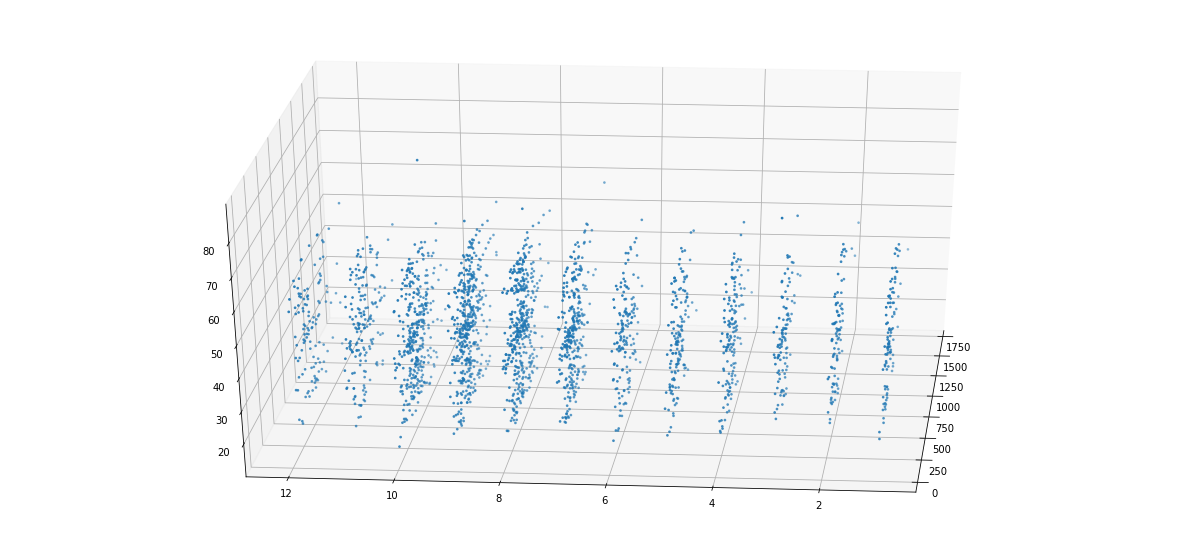

In [88]:
fig = plt.figure(figsize=(21,10))
ax = fig.add_subplot(111, projection = "3d")
ax.scatter(df_cto['avg_purchase'], df_cto["property_valuation"], df_cto["age"], s=3)

ax.view_init(30, 185)
plt.show

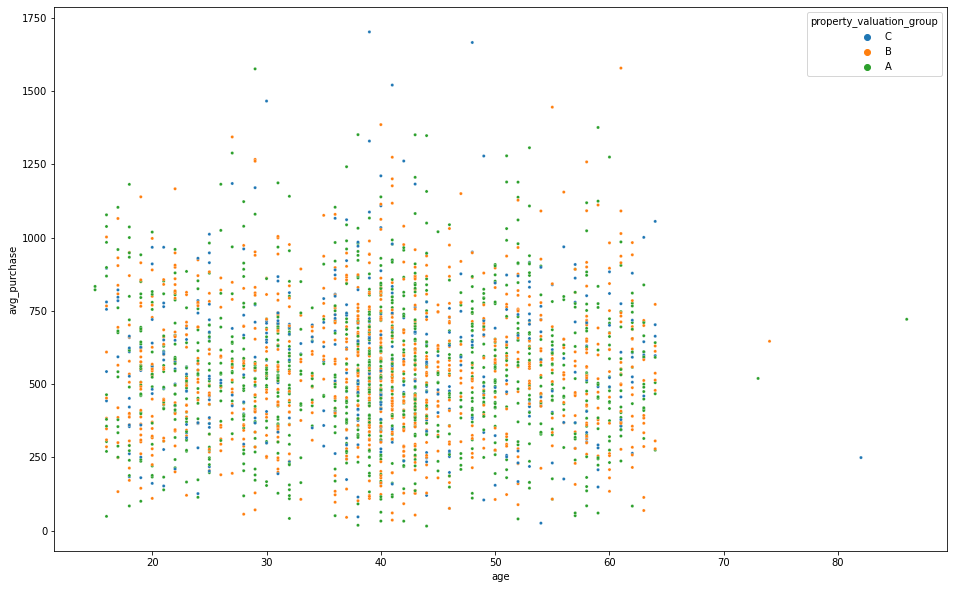

In [99]:
fig, ax = plt.subplots(figsize=[16,10])
sns.scatterplot(data=df_cto, x='age', y="avg_purchase", hue="property_valuation_group", s=10)


In [ ]:

# poly = PolynomialFeatures(degree = 4)
# X_poly = poly.fit_transform(X)

# poly.fit(X_poly, y)
# lin2 = LinearRegression()
# lin2.fit(X_poly, y)

# # Visualising the Polynomial Regression results
# plt.scatter(X, y, color = 'blue')
 
# plt.plot(X, lin2.predict(poly.fit_transform(X)), color = 'red')
# plt.title('Polynomial Regression')
# plt.xlabel('Temperature')
# plt.ylabel('Pressure')
 
# plt.show()

In [80]:
keep_cols4 = ["age", "avg_purchase"]
df_mod = df_cto[keep_cols4]

X = df_mod.iloc[:, 0:1].values
y = df_mod.iloc[:, 1].values

In [104]:
poly = PolynomialFeatures(degree = 2)
X_poly = poly.fit_transform(X)

poly.fit(X_poly, y)
lin = LinearRegression()
lin.fit(X_poly, y)

LinearRegression()

<function matplotlib.pyplot.show>

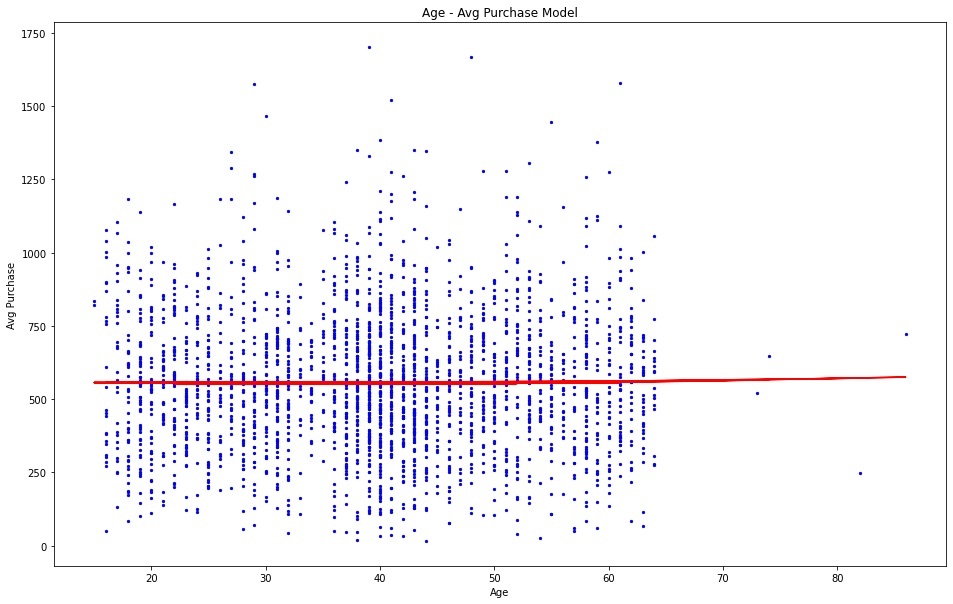

In [105]:
fig, ax = plt.subplots(figsize=[16,10])
plt.scatter(X, y, color = "blue", s=5)
plt.plot(X, lin.predict(poly.fit_transform(X)), color = "red")
plt.title("Age - Avg Purchase Model")
plt.xlabel("Age")
plt.ylabel("Avg Purchase")
plt.show

K-Means Clustering

In [103]:
scaler = StandardScaler().fit(df_mod.values)
features = scaler.transform(df_mod.values)
features = pd.DataFrame(features, columns=keep_cols4)
features.head()

,age,avg_purchase
0,1.950047,-1.176365
1,-0.210981,0.795318
2,0.349286,-0.679716
3,-1.331513,-0.201107
4,1.789971,0.279076


In [110]:
# SSE = []

# for cluster in range(1,10):
#     kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
#     kmeans.fit(newdf)
#     SSE.append(kmeans.inertia_)

# # converting the results into a dataframe and plotting them

# frame = pd.DataFrame({'Cluster':range(1,10), 'SSE':SSE})
# plt.figure(figsize=(12,6))
# plt.plot(frame['Cluster'], frame['SSE'], marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Inertia')


SSE = []
for cluster in range(1,10):
  kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init = "k-means++")
  kmeans.fit(features)
  SSE.append(kmeans.inertia_)

  frame = pd.DataFrame({"Cluster" : range(1, 10), "SSE" : SSE})
  plt.figure(fitsize = (12, 6))
  plt.plot(frame["Cluster"], frame["SSE"], marker = "o")
  plt.xlabel("Number of clusters")
  plt.ylabel("Inertia")

TypeError: ignored